# 3. Deform
Most of the time the initial density is too low. We need to invoke `deform` to push the density closer to real density.

## 3.1. Copy files

In [6]:
from pathlib import Path
from shutil import copy
cwd = Path.cwd()

source = cwd.parent/'2. Minimize'
copy(source/'data.new.lmp', cwd/'data.lmp')
copy(source/'CH.airebo', cwd)

'c:\\Users\\fitbe\\OneDrive\\Desktop\\AO Tutorial\\LAMMPS\\3. Deform\\CH.airebo'

## 3.2. Input file

In [7]:
%%writefile in.lmp
#---------- Initization ----------#
units metal
dimension 3
boundary p p p
atom_style charge

#---------- structure ----------#
read_data data.lmp

#---------- Force Field ----------#
pair_style airebo 3.0
pair_coeff * * CH.airebo C H

#---------- Simulation ----------#
# Timestep
timestep 0.0005             # Timestep in ps
variable ttotal equal 1     # Total simulation time in ps
variable thermo equal 10    # Number of thermo data
variable dump equal 10      # Number of dump frames
variable Ntotal equal ${ttotal}/dt
variable Nthermo equal ${Ntotal}/${thermo}
variable Ndump equal ${Ntotal}/${dump}

# Variables
variable random equal 123456
variable Tset equal 300
variable Tdamp equal 100*dt

# Fix
velocity all create ${Tset} ${random} mom yes rot yes dist gaussian
fix 1 all deform 1 x final 0 ${size} y final 0 ${size} z final 0 ${size}
fix 2 all nvt temp ${Tset} ${Tset} ${Tdamp}

# Thermo
thermo ${Nthermo}
thermo_style custom step time temp pe press lz density

# Dump
dump 1 all custom ${Ndump} dump.lmp id type element mass x y z vx vy vz
dump_modify 1 element C H

run ${Ntotal}

#---------- End ----------#
write_data data.new.lmp

Overwriting in.lmp


## 3.3. Run LAMMPS

In [8]:
# Define a function to calculate cubic simulation box size by defining density and number of molecules
def get_size(density, num):
    # Molecular weight
    C = 12.0107
    H = 1.00794
    PE = 20*C + 42*H

    # Unit conversion
    amu_g = 1.66054e-24
    Å_cm = 1e-8
    amuÅ3_gcm3 = amu_g / (Å_cm**3)
    density_amuÅ3 = density / amuÅ3_gcm3
    volume = num*PE / density_amuÅ3

    # Assume cubic box
    size = round(volume**(1/3), 2)
    return size

In [9]:
density = 0.6  # g/cm^3
num = 30  # Number of molecules
size = get_size(density, num)
print(f'size = {size} Å')

size = 28.63 Å


In [10]:
!lmp -i in.lmp -l log.lmp -v size {size}

LAMMPS (2 Aug 2023 - Update 1)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Loaded 1 plugins from C:\Users\fitbe\AppData\Local\LAMMPS 64-bit 2Aug2023 with GUI\plugins
Reading data file ...
  orthogonal box = (0 0 0) to (34.680118 34.680118 34.680118)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  1860 atoms
  reading velocities ...
  1860 velocities
  read_data CPU = 0.017 seconds
Reading airebo potential file CH.airebo with DATE: 2011-10-25
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 12.2
  ghost atom cutoff = 12.2
  binsize = 6.1, bins = 6 6 6
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair airebo, perpetual
      attributes: full, newton on, ghost
      pair build: full/bin/ghost
      stencil: full/ghost/bin/3d
      bin: standard
Setting up Verlet run ...
  Unit style 

## 3.4. Visualize the structure
Open the "dump.lmp" using OVITO software.

## 3.5. Log file

In [11]:
# Import packages
from lammps.formats import LogFile
import pandas as pd

C:\Users\fitbe\AppData\Local\Temp\ipykernel_8020\3674864415.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [12]:
# Load log file
file = LogFile(filename='log.lmp')

# The file contains a list of runs and errors. We only have one run.
# Each run is a dictionary with thermo fields as keys, storing the values over time.
run = file.runs[0]

# Convert to pandas DataFrame
log = pd.DataFrame(run)

# Print
log

Step  Time       Temp     PotEng       Press         Lz   Density
0      0.0   0.0  300.00000 -7826.7258  1839.90600  34.680118  0.337458
1    200.0   0.1  191.52789 -7783.1797  1434.70790  34.075106  0.355754
2    400.0   0.2  244.89043 -7774.2493 -1573.22860  33.470094  0.375397
3    600.0   0.3  285.48915 -7762.1428  1507.81350  32.865082  0.396513
4    800.0   0.4  312.91797 -7755.0948   859.74190  32.260071  0.419243
5   1000.0   0.5  290.91431 -7759.8728   109.99161  31.655059  0.443744
6   1200.0   0.6  304.96975 -7761.8939  3518.88550  31.050047  0.470192
7   1400.0   0.7  294.93478 -7762.2073  1026.64470  30.445035  0.498784
8   1600.0   0.8  294.64370 -7764.9220  2078.32900  29.840024  0.529742
9   1800.0   0.9  304.11774 -7762.4140  2127.63540  29.235012  0.563316
10  2000.0   1.0  297.61329 -7766.4442  3515.01040  28.630000  0.599788

<Axes: xlabel='Step', ylabel='Potential Energy (eV)'>

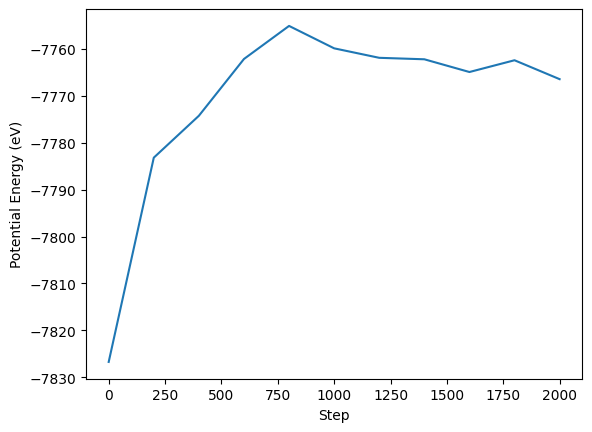

In [13]:
# Plot the potential energy
log.plot(x='Step', y='PotEng', ylabel='Potential Energy (eV)', legend=False)

<Axes: xlabel='Step', ylabel='Density (g/cm^3)'>

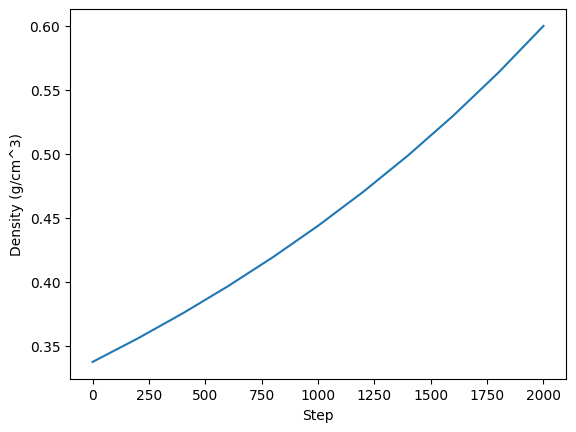

In [14]:
# Plot the density
log.plot(x='Step', y='Density', ylabel='Density (g/cm^3)', legend=False)

## 3.6. Species
Sometimes `deform` is too aggressive so that molecules are connected to each other. That's why we check the species.

We invoke `reaxff/species` to extract species. Copy "ffield.reax.cho" from local "Potential" folder from LAMMPS. This force field is famous for C-H-O systems under combustion.

In [18]:
%%writefile in.spe
#---------- Initization ----------#
units real
dimension 3
boundary p p p
atom_style charge

#---------- structure ----------#
read_data data.new.lmp

#---------- Force Field ----------#
pair_style reaxff NULL checkqeq no
pair_coeff * * ffield.reax.cho C H

#---------- Simulation ----------#
fix 1 all reaxff/species 1 1 1 spe.spe element C H

run 1
#---------- End ----------#

Overwriting in.spe


In [19]:
!lmp -i in.spe -l log.spe

LAMMPS (2 Aug 2023 - Update 1)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Loaded 1 plugins from C:\Users\fitbe\AppData\Local\LAMMPS 64-bit 2Aug2023 with GUI\plugins
Reading data file ...
  orthogonal box = (0 0 0) to (28.63 28.63 28.63)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  1860 atoms
  reading velocities ...
  1860 velocities
  read_data CPU = 0.013 seconds
Reading potential file ffield.reax.cho with DATE: 2011-02-18

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE

Your simulation uses code contributions which should be cited:
- pair reaxff command: doi:10.1016/j.parco.2011.08.005
The log file lists these citations in BibTeX format.

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE

Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 12
  ghost atom cuto

In [20]:
!type spe.spe

#  Timestep    No_Moles    No_Specs      C20H42
          1          30           1          30
